In [1]:
import os
import cv2
import random

### Dataset cropping

In order to enhance detection, I come up with the following idea: train a model on already sliced dataset and then perform detection using SAHI. SAHI slices its input in full format and perform detectin using frames of size used during training. Cropped image should brin following advantages: ball is larger and occupies larger space and thus model should learn its features more easily, secondly, I am able to crop the image precisely to size of YOLO input (640 in this case) and thus the input is not repeatedly squeezed.

In order to create cropped dataset, I implemented a function `slice_dataset` which crops image around the bounding box at random offset both verticaly and horizontaly:

In [ ]:
def load_yolo_labels(label_path):
    with open(label_path, "r") as f:
        for line in f.readlines():
            cls, x, y, w, h = map(float, line.strip().split())
            if cls == 0:
                return cls, x, y, w, h
            else: 
                print("No ball object")

def save_yolo_labels(label_path, label):
    with open(label_path, "w") as f:
        cls, x, y, w, h = label
        f.write(f"{int(cls)} {x:.6f} {y:.6f} {w:.6f} {h:.6f}\n")

def slice_dataset(
    images_dir,
    labels_dir,
    output_images_dir,
    output_labels_dir,
    slice_size=640,
    crops_per_image=3
):
    os.makedirs(output_images_dir, exist_ok=True)
    os.makedirs(output_labels_dir, exist_ok=True)

    for img_file in os.listdir(images_dir):
        if not img_file.lower().endswith((".jpg", ".png", ".jpeg")):
            print("No image")
            continue

        img_path = os.path.join(images_dir, img_file)
        label_path = os.path.join(labels_dir, os.path.splitext(img_file)[0] + ".txt")

        if not os.path.exists(label_path):
            print("No label")
            continue

        img = cv2.imread(img_path)
        height, width = img.shape[:2]
        label = load_yolo_labels(label_path)
        print(height, width)


        if not label:
            print('No ball object')
            continue

        for k in range(crops_per_image):
            
            cls, x, y, w, h = label

            x = int(x*width)
            y = int(y*height)
            w = int(w*width)
            h = int(h*height)

            print(img_path)
            print('w, h', w, h)
            print('width, height', width, height)
            print('slice_size', slice_size)
            print('x, y', x, y)


            # choose upper left point at random as baseline for crop
            if x + slice_size < width:
                if x - slice_size < 0:
                    x1 = random.randint(0, x)
                else:
                    x1 = random.randint(x-slice_size, x)
            else:
                if x - slice_size < 0:
                    x1 = random.randint(0, width-slice_size)
                else:
                    x1 = random.randint(x-slice_size, width-slice_size)
                


            if y + slice_size < height:
                y1 = random.randint(max(0, y-slice_size), y)
            else:
                y1 = random.randint(max(0, y-slice_size), height-slice_size)
                
            # x1 = random.randint(max(0, x-slice_size+w), max(width-slice_size-w, x - slice_size -w))
            # y1 = random.randint(max(0, y-slice_size+h), max(height-slice_size-h, y -slice_size- h))

            # x1 = random.randint(max(0, x-slice_size+w), max(width-slice_size-w, x - slice_size +w))
            # y1 = random.randint(max(h, y-slice_size+h), max(height-slice_size+h, y -slice_size+ h))

            
            y2 = y1 + slice_size
            x2 = x1 + slice_size
            print(x1, y1, x2, y2)

            crop = img[y1:y2, x1:x2]

            x_new = (x-x1)/slice_size
            y_new = (y-y1)/slice_size
            w_new = w/slice_size
            h_new = h/slice_size

            new_labels = cls, x_new, y_new, w_new, h_new

            out_name = f"{os.path.splitext(img_file)[0]}_crop{k}.jpg"
            out_img_path = os.path.join(output_images_dir, out_name)
            out_label_path = os.path.join(output_labels_dir, os.path.splitext(out_name)[0] + ".txt")

            cv2.imwrite(out_img_path, crop)
            save_yolo_labels(out_label_path, new_labels)

            print(f"Saved crop: {out_img_path}")

In [13]:
slice_dataset(
    images_dir='datasets/new/images/val/',
    labels_dir='datasets/new/labels/val/',
    output_images_dir='datasets/new_sliced/images/val/',
    output_labels_dir='datasets/new_sliced/labels/val/',
    slice_size=640,
    crops_per_image=1
)

720 1280
datasets/new/images/val/b90e80f0-frame_92.jpg
w, h 12 11
width, height 1280 720
slice_size 640
x, y 726 247
87 3 727 643
Saved crop: datasets/new_sliced/images/val/b90e80f0-frame_92_crop0.jpg
720 1280
datasets/new/images/val/5593ee5a-frame_612.jpg
w, h 32 31
width, height 1280 720
slice_size 640
x, y 446 481
318 48 958 688
Saved crop: datasets/new_sliced/images/val/5593ee5a-frame_612_crop0.jpg
720 1280
datasets/new/images/val/6b69849f-frame_79.jpg
w, h 9 6
width, height 1280 720
slice_size 640
x, y 404 237
172 54 812 694
Saved crop: datasets/new_sliced/images/val/6b69849f-frame_79_crop0.jpg
720 1280
datasets/new/images/val/230b1a1a-frame_1314.jpg
w, h 13 10
width, height 1280 720
slice_size 640
x, y 565 332
479 2 1119 642
Saved crop: datasets/new_sliced/images/val/230b1a1a-frame_1314_crop0.jpg
720 1280
datasets/new/images/val/f4586182-frame_887.jpg
w, h 11 9
width, height 1280 720
slice_size 640
x, y 504 270
232 22 872 662
Saved crop: datasets/new_sliced/images/val/f4586182-fr

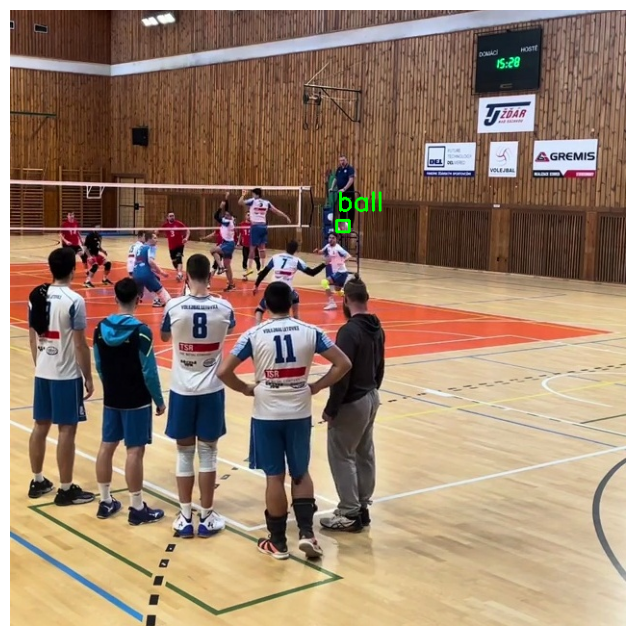

In [15]:
# script for visualizing cropped image to ensure correct bbox coordinates


import cv2
import matplotlib.pyplot as plt

def draw_yolo_labels(image_path, label_path, class_names=None):
    # Load image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convert BGR → RGB for plotting
    h, w = img.shape[:2]


    with open(label_path, "r") as f:
        for line in f.readlines():
            cls, x, y, bw, bh = map(float, line.strip().split())


            x_center, y_center = int(x * w), int(y * h)
            box_w, box_h = int(bw * w), int(bh * h)

            x1 = int(x_center - box_w / 2)
            y1 = int(y_center - box_h / 2)
            x2 = int(x_center + box_w / 2)
            y2 = int(y_center + box_h / 2)

            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)


            if class_names:
                label = class_names[int(cls)]
            else:
                label = str(int(cls))

            cv2.putText(img, label, (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis("off")
    plt.show()



image_file = "datasets/new_sliced/images/val/1d770dc8-frame_150_crop0.jpg"
label_file = "datasets/new_sliced/labels/val/1d770dc8-frame_150_crop0.txt"
classes = ["ball"]

draw_yolo_labels(image_file, label_file, classes)